# Quickstart :RTB人工シミュレーションとデータセット(離散空間)
このノートブックではReal-Time Bidding (RTB)人工データセットでのオフ方策学習(OPE)とオフライン強化学習(Offline RL)の実行例を紹介します。

RTBシミュレーションとデータセットの例は5つのステップから成り立っています。

0. RTB人工シミュレーション環境の設定とオンライン強化学習
1. 人工データの生成
2. オフライン強化学習
3. オフ方策評価とオフライン強化学習手法の評価
4. オフ方策評価手法の評価

\* このライブラリは，オンラインとオフラインの方策・モデルベース評価で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています.   
\*また[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考に実装しています.

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.2.1


In [5]:
# random stateの設定
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 0. RTB人工シミュレーション環境の設定とオンライン強化学習
まず初めにRTB環境を紹介します．

#### 強化学習でのRTB環境のセットアップ
RTBにおいて強化学習エージェントの目的は，予算制約が与えられもとで，1エピソード内のKPI(クリックやコンバージョン)を最大化することです. KPIを最大にするために，エージェントは入札価格関数パラメータ $\alpha$ を選択します．
入札価格関数パラメータ $\alpha$ を利用することで下の入札価格を決定します．\
$bid_{t，i} = \alpha \cdot r^{\ast}$，
ここで$r^{\ast}$はKPIsの予測または期待値を表します.

この問題を制約付きマルコフ決定過程(CMDP)として定式化します.

- `タイムステップ`: 1エピソード(一日，1週間)に含まれるタイムステップ(24時間， 数日など).
- `状態`: それぞれのタイムステップで，環境からフィードバックが返ってきます.
  - タイムステップ
  - 残予算
  - 一つ前のタイムステップでのインプレッション単位の特徴(予算消費率，1インプレッションあたりのコスト，オークション落札率，報酬)
  - 一つ前のタイムステップでの入札関数パラメータ(強化学習エージェントが選ぶ行動) 
- `行動`: エージェントはKPIを最大化するために入札価格パラメータ$\alpha$を選択します.
- `報酬`: 1タイムステップあたりの得られたトータルのクリックまたはコンバージョンの数.
- `制約`: あらかじめ決められた1エピソードあたりの超えてはいけない予算．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).


In [9]:
# 環境のセットアップ
env = RTBEnv(random_state=random_state)

In [10]:
# ランダムに行動を選択するエージェントを定義
agent = OnlineHead(
    ContinuousRandomPolicyConfig(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # 方策が取りうる最小の値
            maximum=10,  # 方策が取りうる最大の値
        )
    ).create(device=device),
    name="random",
)
agent.build_with_env(env)

In [11]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述できる
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [12]:
# 環境からのフィードバック
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


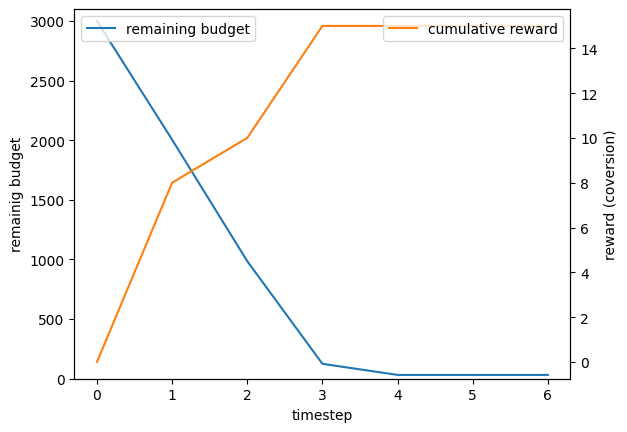

In [13]:
# 累積報酬と残予算の変遷を可視化しています
# 目的は予算制約の中で強化学習を利用して, 累積報酬を最大化する方策を得ることです
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# プロット
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

ランダム方策が早く予算を消費してしまっています．
目標は予算制約を満たしつつ, 報酬を最大化するような入札価格パラメータ(行動)を選択する方策を得ることです．

より詳細に環境の引数を確認したい場合は，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).

#### オンライン強化学習と方策の比較
まずは方策価値のオンラインでの推定に基づき，オンライン強化学習で学習した方策とランダム方策を比較します．

In [14]:
# SCOPE-RLで実装されている離散行動空間に対する標準的な環境
env = gym.make("RTBEnv-discrete-v0")
print(env.action_meaning)

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [15]:
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)
# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)
# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.3,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [18]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [18]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-30 17:48:26 [warning  ] Parameters will be reinitialized.


Text(0, 0.5, 'episode reward')

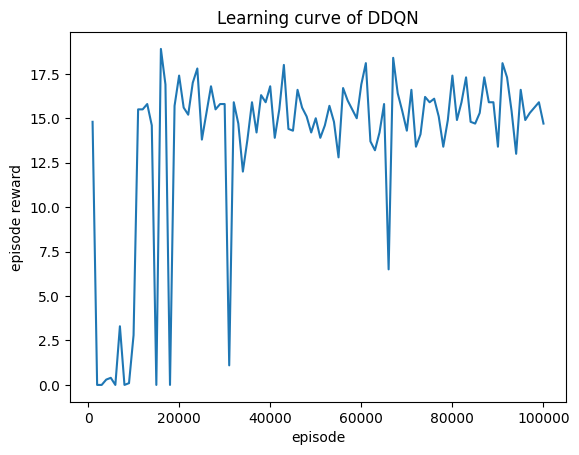

In [20]:
# モデルの学習曲線
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [19]:
random = DiscreteRandomPolicyConfig().create()
random.build_with_env(env)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

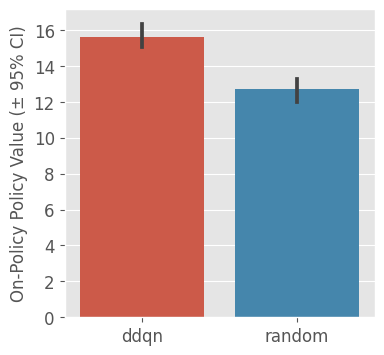

In [20]:
# オンラインでの性能比較
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [21]:
# ddqn方策のオンライン評価による方策価値
# ランダム方策より大きく改善（約20%）
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("relative improvement:", (ddqn_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 0.28032786885245903


`scope_rl.ope.online`では，以下の関数を用いて方策の性能をオンラインで評価できます.

(統計量)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(可視化)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. 人工データの生成
前章ではシミュレーション環境をオンライン環境とみなし，どのようにどのようにオンライン強化学習やオンラインでの性能評価を行うか確認しました．今回のようにシミュレーション環境上では簡単にエージェントを学習することができますが，実環境でオンラインのデータ収集や逐次的意思決定を行うことにはリスクを伴います．そこでオフライン強化学習ではデータ収集方策$\pi_0$から集められた以下のオフラインのログデータのみを利用することで，新たな方策を学習することを考えます．

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

`SyntheticDataset` は以下の引数を持っています:
- `env`: 前のセクションで紹介したRTB環境を定義.
- `state_keys`: state変数の名前
- `max_episode_steps`: 1エピソードにおける最大の時刻.
- `info_keys`: キーと情報のタイプを含んだ辞書


In [22]:
# SCOPE-RLから必要なモジュールをインポート
from scope_rl.policy import EpsilonGreedyHead

In [23]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [24]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

In [26]:
train_logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.24381775e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         9.90049751e-01, 6.00000000e+00, 2.15443469e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 5.82000000e+02, 6.52951699e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

In [29]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [27]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

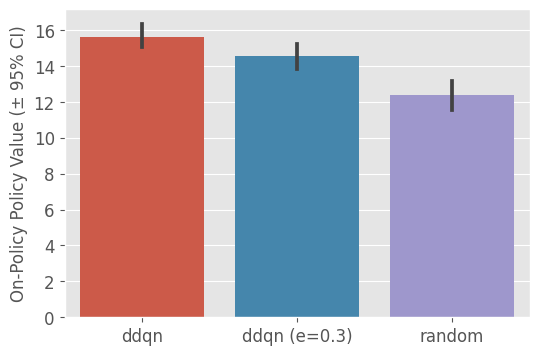

In [28]:
# オンラインでの性能比較
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [29]:
# ログデータの統計量
df = pd.DataFrame()
df['adjust rate'] = train_logged_dataset['state'][:, 6]
df['average bid price'] = train_logged_dataset['info']['average_bid_price']
df['impression'] = train_logged_dataset['info']['impression']
df['click'] = train_logged_dataset['info']['click']
df['conversion'] = train_logged_dataset['info']['conversion']
df['winning rate'] = train_logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.338365,75.576464,68.830157,7.317400,1.823457,0.366040,0.051487,0.110896
std,1.963969,105.805471,84.556172,9.566505,2.826144,0.411562,0.071177,0.167850
min,0.000106,4.045918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166810,8.036649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.464159,36.129331,3.000000,0.000000,0.000000,0.079218,0.000000,0.000000
75%,1.291550,69.141414,161.000000,16.000000,3.000000,0.823834,0.102410,0.200000
max,10.000000,546.900000,277.000000,46.000000,19.000000,1.000000,0.999997,0.999998


より詳細にデータ収集と可視化について知りたい場合は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb).

## 2. オフライン強化学習
この章では実環境と相互作用せずに，ログデータのみから新しい方策を学習する方法を紹介します．
オフライン強化学習のアルゴリズムは [d3rlpy](https://github.com/takuseno/d3rlpy)に実装されているものを利用します．

In [33]:
# d3rlpyのモジュールのインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig

In [34]:
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [45]:
# Conservative Q-Learning 方策を利用
cql = DiscreteCQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [48]:
# モデルの保存
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [49]:
# モデルのリロード
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2023-07-30 17:55:29 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

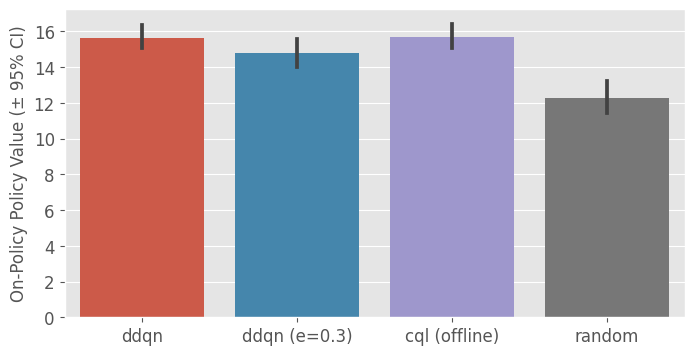

In [47]:
# オンラインでの性能比較
# オフラインで学習した方策もオンラインで学習した方策と同等程度の性能を達成
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. オフ方策評価とオフライン強化学習手法の評価
前章ではオンラインの性能評価 (A/Bテスト) により学習した方策の性能を確認しました．しかし，実務においては方策の性能が悪い場合に顧客の満足度を毀損してしまうなど，A/Bテストにも大きなリスクが伴うことが知られています．ここで学習した方策が実環境でどのように動作するかを事前に見積もるために，オフラインでの方策性能の評価を行います．

#### 推定目標
ここでは，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [50]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [51]:
# 評価方策を定義
cql_ = EpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = EpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = EpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [52]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# 計算に時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [54]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [55]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [56]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [57]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [58]:
# 推定した方策性能
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     15.690000               1.000000
 dm            17.830122               1.136400
 tis            0.013578               0.000865
 pdis          10.765804               0.686157
 dr            14.412143               0.918556
 sntis         14.999998               0.956023
 snpdis        12.922537               0.823616
 sndr          13.945249               0.888799,
 'ddqn':            policy_value  relative_policy_value
 on_policy     15.620000               1.000000
 dm            12.282429               0.786327
 tis            0.000000               0.000000
 pdis          12.686455               0.812193
 dr            16.830240               1.077480
 sntis          0.000000               0.000000
 snpdis        15.726926               1.006845
 sndr          17.240683               1.103757,
 'random':            policy_value  relative_policy_value
 on_policy     12.570000               1.000000
 dm          

In [59]:
# 推定した方策性能の信頼区間
policy_value_interval_df_dict

{'cql':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  15.667900         14.840000         16.395750
 dm         17.830228         17.827503         17.833102
 tis         0.012627          0.000000          0.040734
 pdis       10.759151          9.630496         12.053074
 dr         14.214093         11.320457         16.318983
 sntis      13.949998          0.000000         44.999995
 snpdis     12.938436         10.765956         15.131035
 sndr       13.666319          9.728964         16.688969,
 'ddqn':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  15.569300         14.924750         16.220500
 dm         12.282437         12.281959         12.282890
 tis         0.000000          0.000000          0.000000
 pdis       12.877326          8.401726         18.559698
 dr         16.870486         15.428369         19.329362
 sntis       0.000000          0.000000          0.000000
 snpdis     16.036555          8.978773         24.83108

## 4. オフ方策評価手法の評価
ope推定量がどのくらい方策価値を推定できているかを評価します．

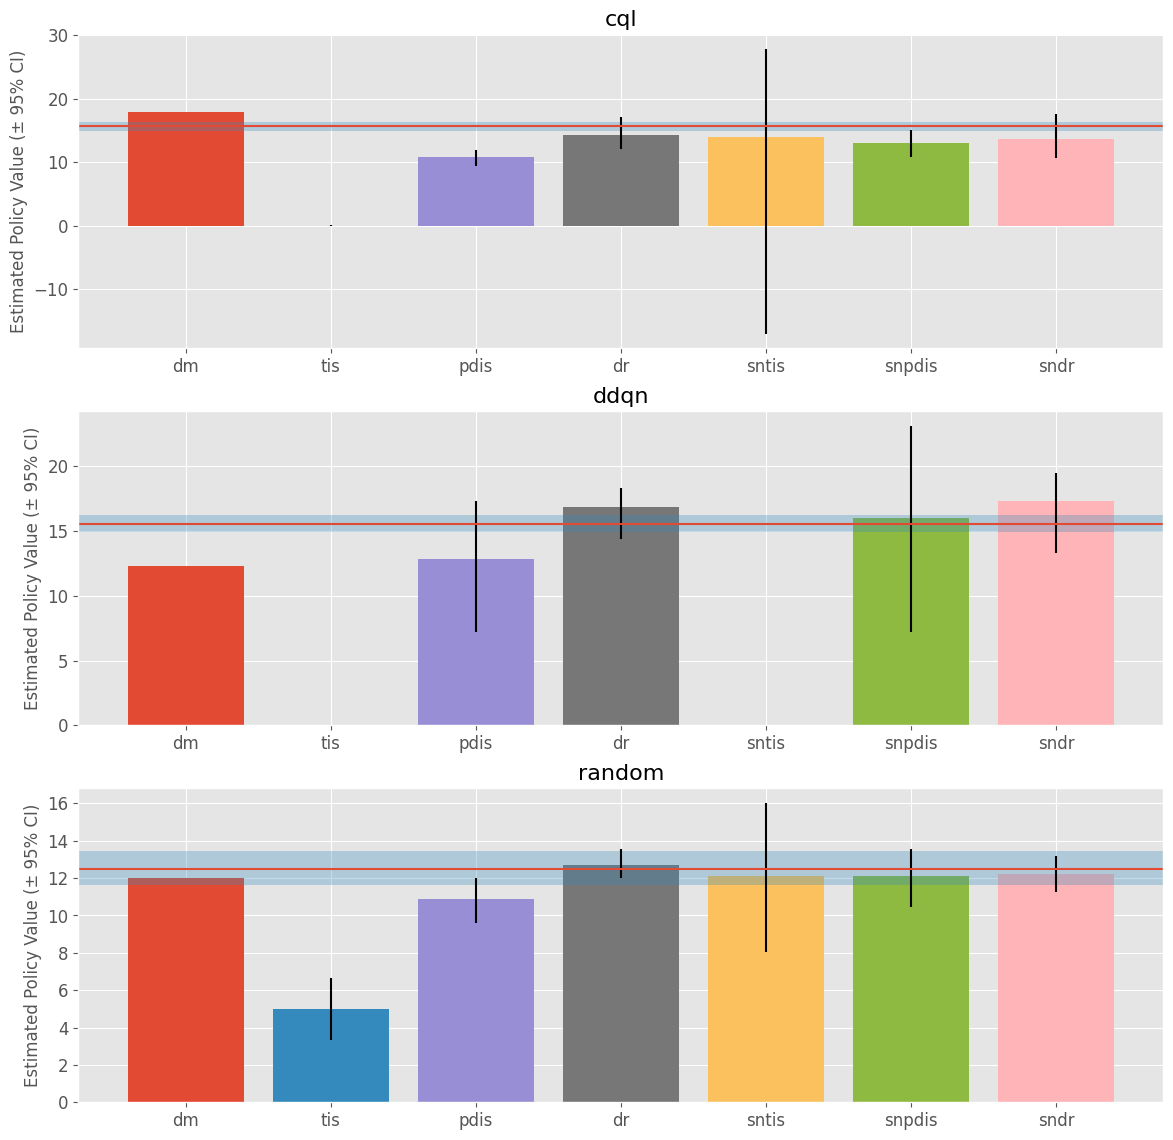

In [60]:
# opeの結果の比較・可視化
# DMはバイアスを発生させやすいですが，分散はとても小さいです．一方（trajectory-wise)の重点サンプリングを利用している推定量はバイアスは小さいものの大きな分散を発生させます．
# またself-normalized推定量がとてもよく推定できています．
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)

In [61]:
# OPEの推定の正確さを測るために2乗誤差を利用します
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,ddqn,random
dm,4.580120,11.139377,0.312904
tis,245.750211,243.984400,59.481848
pdis,24.247704,8.605686,3.429670
dr,1.632919,1.464681,0.016577
sntis,0.476102,243.984400,0.703988
snpdis,7.658852,0.011433,0.429814
sndr,3.044155,2.626613,0.128472


OPEのより発展的なトピック(累積分布関数の推定など) やオフ方策選択 (OPS) は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb). 

OPEのより発展的な推定量 (state(-action) marginal estimators や double reinforcement learningなど) は，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_discrete_zoo_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_zoo_ja.ipynb). 

連続的な行動空間に対する例は，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb).

## 参考文献

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.